# loading the dataframe

In [1]:
import pandas as pd
df = pd.read_csv('Shoplifting.csv')
df

,Shoplifting001_x264_0,Shoplifting,0
0,Shoplifting001_x264_1,Shoplifting,0
1,Shoplifting001_x264_2,Shoplifting,0
2,Shoplifting001_x264_3,Shoplifting,0
3,Shoplifting001_x264_4,Shoplifting,0
4,Shoplifting001_x264_5,Shoplifting,0
...,...,...,...
890,Shoplifting054_x264_27,Shoplifting,0
891,Shoplifting054_x264_28,Shoplifting,0
892,Shoplifting054_x264_29,Shoplifting,0
893,Shoplifting054_x264_30,Shoplifting,0


In [2]:
df['Shoplifting001_x264_0'] = df['Shoplifting001_x264_0'] + ".mp4"
df

,Shoplifting001_x264_0,Shoplifting,0
0,Shoplifting001_x264_1.mp4,Shoplifting,0
1,Shoplifting001_x264_2.mp4,Shoplifting,0
2,Shoplifting001_x264_3.mp4,Shoplifting,0
3,Shoplifting001_x264_4.mp4,Shoplifting,0
4,Shoplifting001_x264_5.mp4,Shoplifting,0
...,...,...,...
890,Shoplifting054_x264_27.mp4,Shoplifting,0
891,Shoplifting054_x264_28.mp4,Shoplifting,0
892,Shoplifting054_x264_29.mp4,Shoplifting,0
893,Shoplifting054_x264_30.mp4,Shoplifting,0


# Making Folders to keep processed data into it.

In [4]:
import os

downloads_folder = r"C:\Users\bhavi\Downloads\Theft Detection Algorithm Assignment"

# Create the new directories within the specified folder
os.makedirs(os.path.join(downloads_folder, "data"))
os.makedirs(os.path.join(downloads_folder, "data", "0"))
os.makedirs(os.path.join(downloads_folder, "data", "1"))


In [7]:
# here we can see that the videos are of 4 seconds each so using 3d convolutions would be useless we would have to process the data on individual frames
# also some videos are of less than 4 seconds and padding 1 second video to 4 second would not make any sense

import cv2
video = cv2.VideoCapture(r"C:\Users\bhavi\Downloads\Theft Detection Algorithm Assignment\Shoplifting\Shoplifting001_x264.mp4/Shoplifting001_x264_1.mp4")
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = video.get(cv2.CAP_PROP_FPS)
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))


print(f"Video Resolution: {width}x{height}")
print(f"Video FPS: {fps}")
print(f"Total Frames: {total_frames}")

Video Resolution: 320x240
Video FPS: 30.0
Total Frames: 120


In [11]:
import os
import cv2

# Define the path to the "Theft Detection Algorithm Assignment" folder in Downloads directory
downloads_folder = r"C:\Users\bhavi\Downloads\Theft Detection Algorithm Assignment"

# Initialize variables
frame_num = 1
zero_cnt = 0
one_cnt = 0

# Iterate through each row in the DataFrame
for i in range(len(df)):
    path = df["Shoplifting001_x264_0"].iloc[i]
    # Construct the full path to the video file
    path = os.path.join(downloads_folder, "Shoplifting", path[:19] + ".mp4", path)
    video = cv2.VideoCapture(path)
    label = df["0"].iloc[i]
    ret, frame = video.read()
    frame_cnt = 1
    
    # Process each frame in the video
    while ret:
        if frame_cnt % 30 == 0:
            if label == 1:
                cv2.imwrite(os.path.join(downloads_folder, "data", str(label), f'f{frame_num}.jpg'), frame)
                one_cnt += 1
            else:
                if zero_cnt < one_cnt or one_cnt < 100:
                    cv2.imwrite(os.path.join(downloads_folder, "data", str(label), f'f{frame_num}.jpg'), frame)
                    zero_cnt += 1
            frame_num += 1
        frame_cnt += 1
        ret, frame = video.read()


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root_dir = 'C:/Users/bhavi/Downloads/Theft Detection Algorithm Assignment/data'
datagen = ImageDataGenerator(
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    root_dir,
    target_size=(320, 240),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    root_dir,
    target_size=(320,240),
    batch_size=32,
    shuffle=False,
    class_mode='binary',
    subset='validation'
)



Found 727 images belonging to 2 classes.
Found 181 images belonging to 2 classes.


In [13]:
from tensorflow import keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.applications import MobileNetV2

batch_size = 32

# Define the base model
base_model = MobileNetV2(include_top=False, input_shape=(320, 240, 3))

# Create a Sequential model
model = Sequential()

# Add the base model
model.add(base_model)

# Flatten the output of the base model
model.add(Flatten())

# Add dense layers
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='sigmoid'))

# Add dropout layer
model.add(Dropout(0.5))

# Add output layer
model.add(Dense(1, activation='sigmoid'))

# Define the path to save model weights
checkpoint_path = "C:/Users/bhavi/Downloads/Theft Detection Algorithm Assignment/model.weights.h5"

# Configure model checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
    mode='max'
)

# Compile the model
model.compile(optimizer=Nadam(weight_decay=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Define reduce learning rate callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5)




9406464/9406464 [==============================] - 1s 0us/step


# training the model


In [15]:
epochs = 20
model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks = [reduce_lr,checkpoint_callback]
)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 0.2149 - accuracy: 0.9298
Epoch 1: val_accuracy did not improve from 0.82873
23/23 [==============================] - 88s 3s/step - loss: 0.2149 - accuracy: 0.9298 - val_loss: 0.9556 - val_accuracy: 0.2707 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.8927
Epoch 2: val_accuracy did not improve from 0.82873
23/23 [==============================] - 71s 3s/step - loss: 0.2466 - accuracy: 0.8927 - val_loss: 0.7475 - val_accuracy: 0.6354 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.1511 - accuracy: 0.9367
Epoch 3: val_accuracy did not improve from 0.82873
23/23 [==============================] - 72s 3s/step - loss: 0.1511 - accuracy: 0.9367 - val_loss: 0.8780 - val_accuracy: 0.6354 - lr: 0.0010
Epoch 4/20
23/23 [==============================] - ETA: 0s - loss: 0.1152 - accuracy: 0.9629
Epoch 4: val_accuracy did not improve from 0.

#### here we can see that the best performance of the model was 90 percent and we saved it's weights automatically and then the model just started to overfit and the accuracy decreases drastically</h1>

# loading the best weihts of the model


In [18]:
model.load_weights("C:/Users/bhavi/Downloads/Theft Detection Algorithm Assignment/model.weights.h5")

## Evaluating the model

In [20]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, top_k_accuracy_score, confusion_matrix
import numpy as np
from keras.models import load_model


# # Evaluate the model on the validation set
predictions = model.predict(val_generator)


# Convert true labels to class labels
true_labels = val_generator.classes
predictions  = predictions >0.5
predictions = predictions.astype(int)
predictions = predictions.flatten()
# # Calculate overall accuracy
overall_accuracy = accuracy_score(true_labels,predictions)

# # Calculate recall, F1 score, and classification report
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
conf_matrix = confusion_matrix(true_labels, predictions)
classification_rep = classification_report(true_labels, predictions)


print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(conf_matrix)
print('Classification Report:')
print(classification_rep)


6/6 [==============================] - 6s 481ms/step
Overall Accuracy: 86.19%
Recall: 86.19%
F1 Score: 85.25%
[[115   0]
 [ 25  41]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       115
           1       1.00      0.62      0.77        66

    accuracy                           0.86       181
   macro avg       0.91      0.81      0.83       181
weighted avg       0.89      0.86      0.85       181



## Confusion Matrix

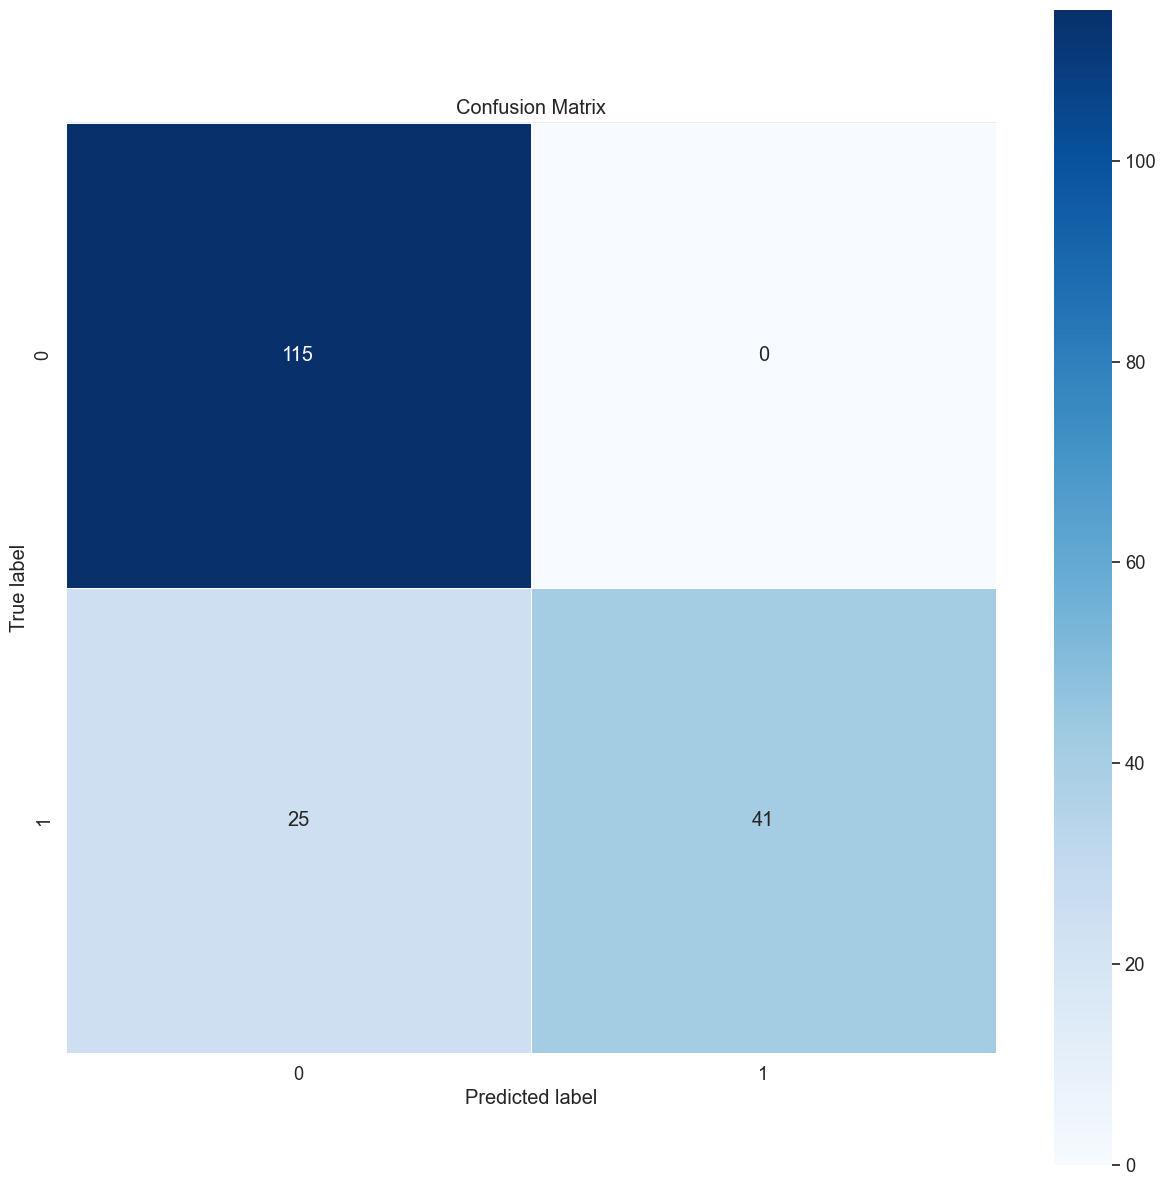

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(15,15))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, linewidths=.5, square=True,)

    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# Example usage:
# Replace y_true and y_pred with your actual and predicted labels

plot_confusion_matrix(true_labels,predictions)